### Get Mnist data and split into train validation and test

In [40]:
import os
# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME')
    predir='/content/ME/My Drive/'

import torch
import numpy as np

# Torch functions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Utility to track progress of a routine.
#from tqdm import tqdm
from tqdm.notebook import trange, tqdm

# Folder with course data
datadir=predir+'LSDA_data/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Drive already mounted at ME; to attempt to forcibly remount, call drive.mount("ME", force_remount=True).


In [41]:
def get_mnist():


    data=np.float64(np.load(datadir+'mnist/MNIST_data.npy'))
    labels=np.float32(np.load(datadir+'mnist/MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:55000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:55000])
    val_dat=data[55000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[55000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])

    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

### Get cifar10 data and split into training, validation and testing.

In [79]:
import h5py

def get_cifar():
    with h5py.File(datadir+'CIFAR/cifar10_train.hdf5', "r") as f:
        tr=f[('data')][:].transpose(0,3,1,2)
        tr_lb=f[('labels')][:]
    train_data=np.float32(tr[0:45000])/255.
    train_labels=tr_lb[0:45000]
    val_data=np.float32(tr[45000:])/255.
    val_labels=tr_lb[45000:]

    with h5py.File(datadir+'CIFAR/cifar10_test.hdf5', "r") as f:
        test_data=f[('data')][:].transpose(0,3,1,2)
        test_data=np.float32(test_data)/255.
        test_labels=f[('labels')][:]
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)


### Get the data

In [108]:
def get_data(data_set):
    if (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="cifar"):
        return(get_cifar())

### The network

In [110]:
class MNIST_Net(nn.Module):
    def __init__(self,pars):
        super(MNIST_Net, self).__init__()

        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=ks[0],padding=ks[0]//2)
        self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1],padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop_final=nn.Dropout(pars.dropout)



        # Run the network one time on one dummy data point of the same
        # dimension as the input images to get dimensions of fully connected
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))

        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)

        self.criterion=nn.CrossEntropyLoss()

    def forward(self, x):

        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)

        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x

    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()

        return loss,correct

    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):

        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, correct



# Run one epoch

In [111]:
def run_epoch(net,epoch,train,pars,num=None,ttype="train"):


    if ttype=='train':
        t1=time.time()
        n=train[0].shape[0]
        if (num is not None):
            n=np.minimum(n,num)
        ii=np.array(np.arange(0,n,1))
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        train_loss=0; train_correct=0

        for j in trange(0,n,pars.batch_size):

                # Transfer the batch from cpu to gpu (or do nothing if you're on a cpu)
                data=torch.torch.from_numpy(tr[j:j+pars.batch_size]).to(pars.device)
                targ=torch.torch.from_numpy(y[j:j+pars.batch_size]).type(torch.long).to(pars.device)

                # Implement SGD step on batch
                loss, correct = net.run_grad(data,targ)

                train_loss += loss.item()
                train_correct += correct.item()


        train_loss /= len(y)
        print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch,
            train_loss, train_correct, len(y),
            100. * train_correct / len(y)))




In [112]:
def net_test(net,val,pars,ttype='val'):
    net.eval()
    with torch.no_grad():
                test_loss = 0
                test_correct = 0
                vald=val[0]
                yval=val[1]
                for j in np.arange(0,len(yval),pars.batch_size):
                    data=torch.from_numpy(vald[j:j+pars.batch_size]).to(device)
                    targ = torch.from_numpy(yval[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                    loss,correct=net.get_acc_and_loss(data,targ)

                    test_loss += loss.item()
                    test_correct += correct.item()

                test_loss /= len(yval)
                SSS='Validation'
                if (ttype=='test'):
                    SSS='Test'
                print('\n{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(SSS,
                    test_loss, test_correct, len(yval),
                    100. * test_correct / len(yval)))


# Run the training. Save the model and test at the end

In [113]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=2
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.dropout=0.
        self.dim=32
        self.pool_size=2
        self.kernel_size=5
        self.mid_layer=256
        self.use_gpu=False

pars=par()

In [114]:
pars.__dict__

{'batch_size': 1000,
 'step_size': 0.001,
 'num_epochs': 2,
 'numtrain': 55000,
 'minimizer': 'Adam',
 'data_set': 'mnist',
 'model_name': 'model',
 'dropout': 0.0,
 'dim': 32,
 'pool_size': 2,
 'kernel_size': 5,
 'mid_layer': 256,
 'use_gpu': False}

In [115]:
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net = MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    net_test(net,val,pars)


net_test(net,test,pars,ttype="test")

# Save the model to a file
if not os.path.isdir(os.path.join(predir,'tmp')):
    os.mkdir(os.path.join(predir,'tmp'))
torch.save(net.state_dict(), os.path.join(predir,'tmp',pars.model_name))

(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 857738


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0006, Accuracy: 46038/55000 (83.71%)


Validation set: Avg. loss: 0.0001, Accuracy: 4840/5000 (96.80%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 52891/55000 (96.17%)


Validation set: Avg. loss: 0.0001, Accuracy: 4922/5000 (98.44%)


Test set: Avg. loss: 0.0001, Accuracy: 9753/10000 (97.53%)



# Reload the model that was saved and continue training

In [116]:
train,val,test=get_data(data_set=pars.data_set)
pars.new_model_name = 'model_continue'
pars.inp_dim=train[0][0].shape
net = MNIST_Net(pars).to(pars.device)

print(pars.__dict__)
state_dict = torch.load(datadir+'tmp/'+pars.model_name, map_location = 'cpu')
net.load_state_dict(state_dict)
net.eval()
for i in range(pars.num_epochs):
    run_epoch(net,i,train,pars, num=pars.numtrain, ttype="train")
    net_test(net,val,pars)

net_test(net,test,pars, ttype="test")
#save model
torch.save(net.state_dict(), datadir+"tmp/"+pars.model_name)

(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 857738
{'batch_size': 1000, 'step_size': 0.001, 'num_epochs': 2, 'numtrain': 55000, 'minimizer': 'Adam', 'data_set': 'mnist', 'model_name': 'model', 'dropout': 0.0, 'dim': 32, 'pool_size': 2, 'kernel_size': [5, 5], 'mid_layer': 256, 'use_gpu': False, 'device': device(type='cuda', index=0), 'inp_dim': (1, 28, 28), 'new_model_name': 'model_continue'}


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0001, Accuracy: 53918/55000 (98.03%)


Validation set: Avg. loss: 0.0000, Accuracy: 4963/5000 (99.26%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0000, Accuracy: 54409/55000 (98.93%)


Validation set: Avg. loss: 0.0000, Accuracy: 4963/5000 (99.26%)


Test set: Avg. loss: 0.0000, Accuracy: 9886/10000 (98.86%)



### Shift the mnist data randomly in both coordinates and create new perturbed test set.


In [117]:
import pylab as py
def get_mnist_trans(test,shift):
    ll=test.shape[0]
    shift2=shift//2
    uu=np.int32((np.random.rand(ll,2)-.5)*shift)
    test_t=[]
    for i,t in enumerate(test):
        tt=np.zeros((28+shift+1,28+shift+1))
        tt[shift2:shift2+28,shift2:shift2+28]=t
        ttt=tt[shift2+uu[i,0]:shift2+uu[i,0]+28,shift2+uu[i,1]:shift2+uu[i,1]+28]
        test_t.append(ttt.reshape(1,28,28))
    test_labels=np.int32(np.load(datadir+'mnist/MNIST_labels.npy'))
    test_trans_dat=np.float32(np.concatenate(test_t,axis=0).reshape((-1,1,28,28)))
    for j in range(20):
      py.subplot(1,20,j+1)
      py.imshow(test_trans_dat[j,0])
      py.axis('off')
    py.show()
    print(test_trans_dat.shape)
    return (test_trans_dat, test_labels[60000:])

(a) Total number of parameters: dim + kernel size + mid_layer = 293

Visualize 32 5x5 kernels from the first convolutional layer

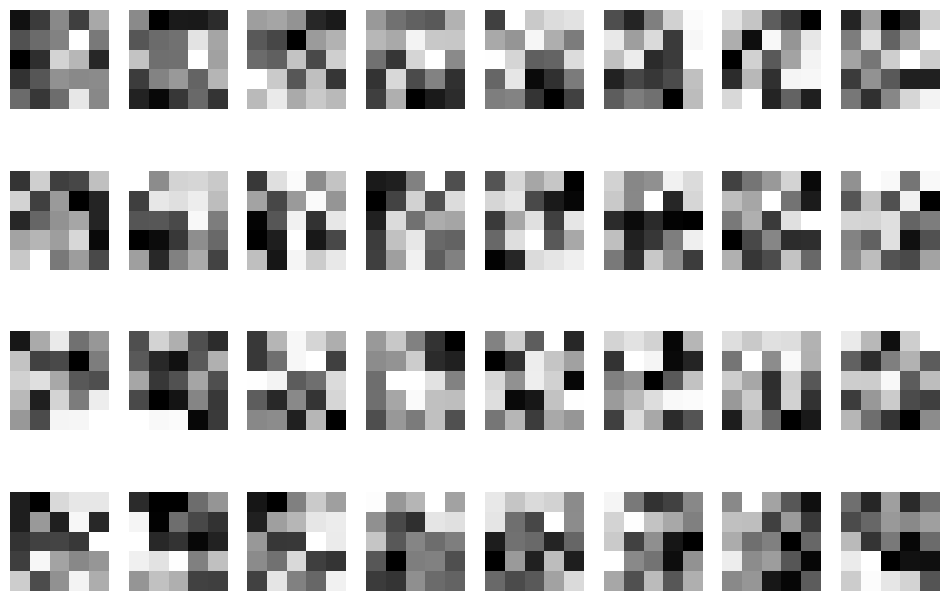

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# Extract 5x5 kernels from the first convolutional layer and move to CPU
kernels_conv1 = net.conv1.weight.data.cpu().numpy()

# Squeeze unnecessary dimensions
kernels_conv1 = kernels_conv1.squeeze(1)

fig, axs = plt.subplots(4, 8, figsize=(12, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(kernels_conv1[i], cmap='gray')
    ax.axis('off')

plt.show()


(b) i. Doubling the parameters in one experiment and halving in another experiment; the parameters are dim, kernel_size, and mid_layer. Remember that pool_size isn't a parameter since it doesn't get updated for each batch.

1. doubling the parameters

In [120]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=4
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.dropout=0.
        self.dim=64
        self.pool_size=2
        self.kernel_size=10
        self.mid_layer=512
        self.use_gpu=False

pars=par()

In [56]:
# use GPU when possible
pars.device = device
pars.kernel_size=[10,10]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net = MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    net_test(net,val,pars)


net_test(net,test,pars,ttype="test")


(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 10, 10])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 10, 10])
conv2.bias torch.Size([64])
fc1.weight torch.Size([512, 3136])
fc1.bias torch.Size([512])
fc_final.weight torch.Size([10, 512])
fc_final.bias torch.Size([10])
tot_pars 1819370


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0005, Accuracy: 47013/55000 (85.48%)


Validation set: Avg. loss: 0.0001, Accuracy: 4887/5000 (97.74%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 53425/55000 (97.14%)


Validation set: Avg. loss: 0.0000, Accuracy: 4936/5000 (98.72%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 54011/55000 (98.20%)


Validation set: Avg. loss: 0.0000, Accuracy: 4953/5000 (99.06%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0000, Accuracy: 54230/55000 (98.60%)


Validation set: Avg. loss: 0.0000, Accuracy: 4971/5000 (99.42%)


Test set: Avg. loss: 0.0000, Accuracy: 9846/10000 (98.46%)



(2) Half the parameters

In [57]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=4
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.dropout=0.
        self.dim=16
        self.pool_size=2
        self.kernel_size=2
        self.mid_layer=128
        self.use_gpu=False

pars=par()

In [58]:
# use GPU when possible
pars.device = device
pars.kernel_size=[10,10]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net = MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    net_test(net,val,pars)


net_test(net,test,pars,ttype="test")


(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 10, 10])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 10, 10])
conv2.bias torch.Size([64])
fc1.weight torch.Size([128, 3136])
fc1.bias torch.Size([128])
fc_final.weight torch.Size([10, 128])
fc_final.bias torch.Size([10])
tot_pars 610922


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0006, Accuracy: 45453/55000 (82.64%)


Validation set: Avg. loss: 0.0001, Accuracy: 4840/5000 (96.80%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 53026/55000 (96.41%)


Validation set: Avg. loss: 0.0000, Accuracy: 4932/5000 (98.64%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53755/55000 (97.74%)


Validation set: Avg. loss: 0.0000, Accuracy: 4952/5000 (99.04%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 54098/55000 (98.36%)


Validation set: Avg. loss: 0.0000, Accuracy: 4959/5000 (99.18%)


Test set: Avg. loss: 0.0001, Accuracy: 9813/10000 (98.13%)



Conclusion: Doubling the parameters have 0.43% more accuracy for 4 epochs.

ii. Design a deeper network with approximately the same number of parameters as
the original network. Report the results. In order to do this, I would decrease the parameters in each layer and instead add few more  layers on convolution-pool phase.

In [121]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=4
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.dropout=0.
        self.dim=16
        self.pool_size=2
        self.kernel_size=4
        self.mid_layer=128
        self.use_gpu=False

pars=par()

In [122]:
class MNIST_Net(nn.Module):
    def __init__(self,pars):
        super(MNIST_Net, self).__init__()

        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=ks[0],padding=ks[0]//2)
        self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1],padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=ks[1],padding=ks[1]//2)
        self.drop3 = nn.Dropout3d(pars.dropout)
        self.pool3=nn.MaxPool3d(kernel_size=2,stride=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=ks[1],padding=ks[1]//2)
        self.drop4 = nn.Dropout3d(pars.dropout)
        self.pool4=nn.MaxPool3d(kernel_size=2,stride=2)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=ks[1],padding=ks[1]//2)
        self.drop5 = nn.Dropout3d(pars.dropout)
        self.pool5=nn.MaxPool3d(kernel_size=2,stride=2)

        self.drop_final=nn.Dropout(pars.dropout)


        # Run the network one time on one dummy data point of the same
        # dimension as the input images to get dimensions of fully connected
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))

        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)

        self.criterion=nn.CrossEntropyLoss()

    def forward(self, x):

        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)

        # Apply relu to a pooled conv3 layer with a drop layer inbetween.
        x = self.drop3(F.relu(self.pool3(self.conv3(x))))
        if self.first:
            print('conv3',x.shape)

        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x

    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()

        return loss,correct

    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):

        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, correct



In [123]:
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net = MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    net_test(net,val,pars)


net_test(net,test,pars,ttype="test")

(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
conv3 torch.Size([1, 64, 3, 3])
input dimension to fc1 576
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 5, 5])
conv3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 5, 5])
conv4.bias torch.Size([256])
conv5.weight torch.Size([512, 256, 5, 5])
conv5.bias torch.Size([512])
fc1.weight torch.Size([128, 576])
fc1.bias torch.Size([128])
fc_final.weight torch.Size([10, 128])
fc_final.bias torch.Size([10])
tot_pars 4428938


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0009, Accuracy: 40776/55000 (74.14%)


Validation set: Avg. loss: 0.0001, Accuracy: 4811/5000 (96.22%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0002, Accuracy: 52492/55000 (95.44%)


Validation set: Avg. loss: 0.0001, Accuracy: 4882/5000 (97.64%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53413/55000 (97.11%)


Validation set: Avg. loss: 0.0000, Accuracy: 4940/5000 (98.80%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 53848/55000 (97.91%)


Validation set: Avg. loss: 0.0000, Accuracy: 4963/5000 (99.26%)


Test set: Avg. loss: 0.0001, Accuracy: 9803/10000 (98.03%)



iii. Pick the best configuration and try it on the full training set and report the result.
(Increasing the parameters seems generally a good idea. Adding layer has potentially some overfitting issue.)

In [60]:
class MNIST_Net(nn.Module):
    def __init__(self,pars):
        super(MNIST_Net, self).__init__()

        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=ks[0],padding=ks[0]//2)
        self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1],padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop_final=nn.Dropout(pars.dropout)



        # Run the network one time on one dummy data point of the same
        # dimension as the input images to get dimensions of fully connected
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))

        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)

        self.criterion=nn.CrossEntropyLoss()

    def forward(self, x):

        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)

        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x

    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()

        return loss,correct

    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):

        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, correct



In [61]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=8
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.dropout=0.
        self.dim=64
        self.pool_size=2
        self.kernel_size=10
        self.mid_layer=512
        self.use_gpu=False

pars=par()

In [62]:
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net = MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    net_test(net,val,pars)


net_test(net,test,pars,ttype="test")

(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([512, 3136])
fc1.bias torch.Size([512])
fc_final.weight torch.Size([10, 512])
fc_final.bias torch.Size([10])
tot_pars 1663370


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0006, Accuracy: 46201/55000 (84.00%)


Validation set: Avg. loss: 0.0001, Accuracy: 4813/5000 (96.26%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 52866/55000 (96.12%)


Validation set: Avg. loss: 0.0001, Accuracy: 4919/5000 (98.38%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53772/55000 (97.77%)


Validation set: Avg. loss: 0.0000, Accuracy: 4944/5000 (98.88%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 54095/55000 (98.35%)


Validation set: Avg. loss: 0.0000, Accuracy: 4953/5000 (99.06%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 54211/55000 (98.57%)


Validation set: Avg. loss: 0.0000, Accuracy: 4965/5000 (99.30%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54417/55000 (98.94%)


Validation set: Avg. loss: 0.0000, Accuracy: 4970/5000 (99.40%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54445/55000 (98.99%)


Validation set: Avg. loss: 0.0000, Accuracy: 4973/5000 (99.46%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54535/55000 (99.15%)


Validation set: Avg. loss: 0.0000, Accuracy: 4967/5000 (99.34%)


Test set: Avg. loss: 0.0000, Accuracy: 9902/10000 (99.02%)



In [63]:
(train_dat, train_labels), (val_dat, val_labels), _ = get_mnist()

(70000, 784)


In [64]:
combined_data = np.concatenate((train_dat, val_dat), axis=0)
combined_labels = np.concatenate((train_labels, val_labels), axis=0)

In [65]:
net_test(net, (combined_data, combined_labels), pars, ttype="full_train")


Validation set: Avg. loss: 0.0000, Accuracy: 59639/60000 (99.40%)



(c)

Handling variability

In [66]:
def evaluate_model(net, test_data, test_labels, verbose=False):
    net.eval()
    correct = 0
    total = 0

    if isinstance(test_data, np.ndarray):
        test_data = torch.from_numpy(test_data).float()
    if isinstance(test_labels, np.ndarray):
        test_labels = torch.from_numpy(test_labels).long()

    with torch.no_grad():
        for data, labels in zip(test_data, test_labels):
            data = data.unsqueeze(0)
            labels = labels.unsqueeze(0)

            data = data.to(net.conv1.weight.device)
            labels = labels.to(net.conv1.weight.device)

            outputs = net(data)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    if verbose:
        print(f'Accuracy of the network on the test data: {accuracy}%')

    return accuracy


(70000, 784)


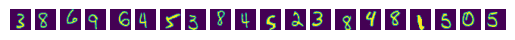

(10000, 1, 28, 28)
(70000, 784)


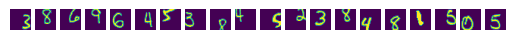

(10000, 1, 28, 28)
(70000, 784)


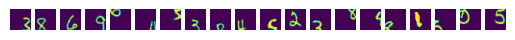

(10000, 1, 28, 28)
(70000, 784)


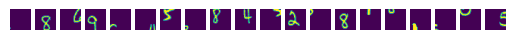

(10000, 1, 28, 28)
(70000, 784)


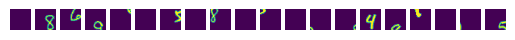

(10000, 1, 28, 28)
(70000, 784)


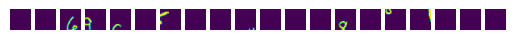

(10000, 1, 28, 28)
(70000, 784)


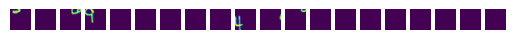

(10000, 1, 28, 28)
(70000, 784)


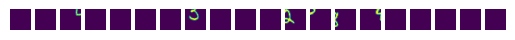

(10000, 1, 28, 28)
(70000, 784)


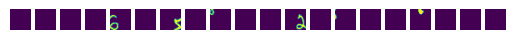

(10000, 1, 28, 28)
(70000, 784)


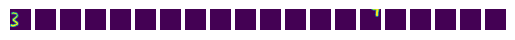

(10000, 1, 28, 28)


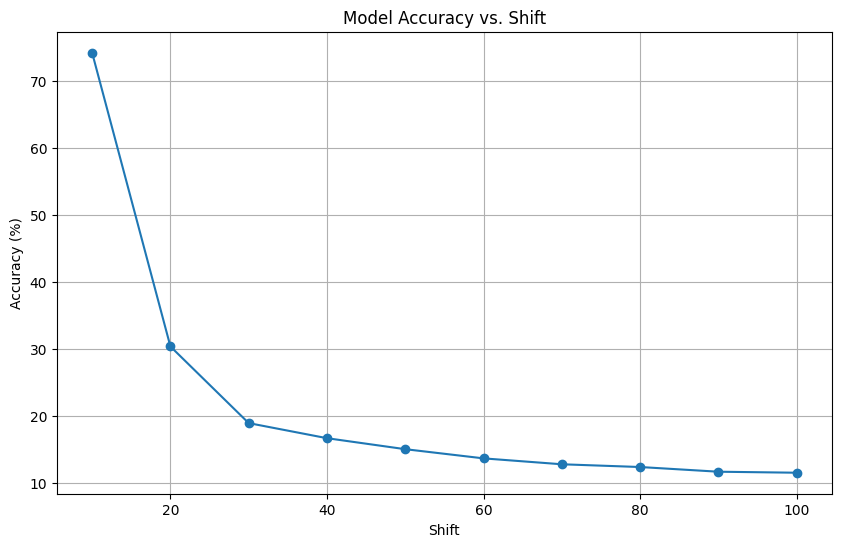

In [67]:
import matplotlib.pyplot as plt

# Initialize lists to store shifts and accuracies
shifts = []
accuracies = []

# Loop through shifts from 10 to 100 in increments of 10
for shift in range(10, 101, 10):
    test_trans_dat, test_labels = get_mnist_trans(get_mnist()[2][0], shift)
    accuracy = evaluate_model(net, test_trans_dat, test_labels)  # Assuming 'evaluate_model' is already defined

    # Append to lists
    shifts.append(shift)
    accuracies.append(accuracy)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(shifts, accuracies, marker='o')
plt.xlabel('Shift')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs. Shift')
plt.grid(True)
plt.show()


Problem 2

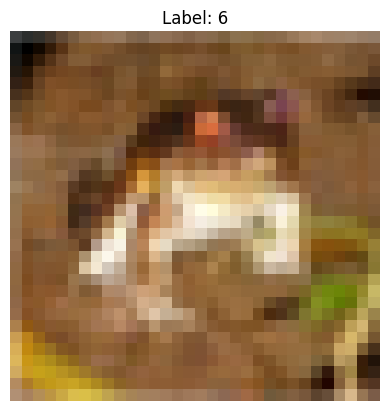

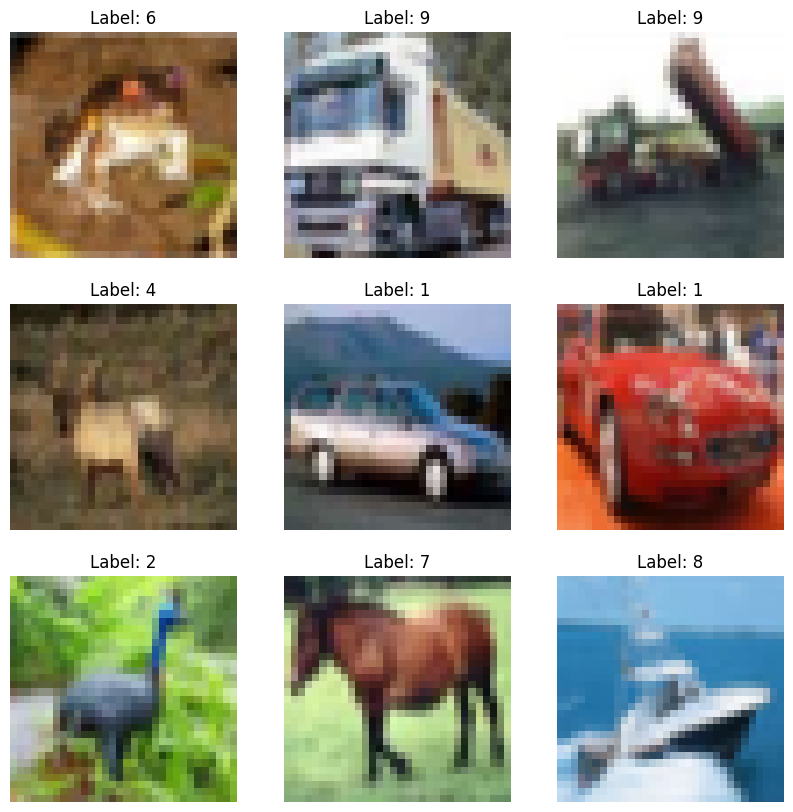

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming get_cifar() returns the data and labels
data, labels = get_cifar()[0]

# Transpose the images from (3, 32, 32) to (32, 32, 3)
data = np.transpose(data, (0, 2, 3, 1))

# Now, data[i] will be a 32x32x3 image and labels[i] will be the label for that image.

# To display a single image
plt.imshow(data[0])
plt.title(f"Label: {labels[0]}")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# To display multiple images in a grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(data[i])
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')  # Turn off axis numbers and ticks

plt.show()

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CIFAR_Net(nn.Module):
    def __init__(self, pars):
        super(CIFAR_Net, self).__init__()

        ks = pars.kernel_size
        ps = np.int32(pars.pool_size)
        self.mid_layer = pars.mid_layer

        # Adjust the input channel to 3 (for RGB)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks[0], padding=ks[0]//2)
        self.pool1 = nn.MaxPool2d(kernel_size=[ps], stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1], padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # ... Continue the rest of your architecture here, if needed

        self.first = True
        if self.first:
            self.forward(torch.zeros((1,) + (3, 32, 32)))

        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr=pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr=pars.step_size)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))

        # Calculating the number of input features for the fully connected layer dynamically
        inp = x.shape[1] * x.shape[2] * x.shape[3]

        if self.first:
            self.first = False
            self.inp = inp

            # Dynamically creating fully connected layers
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1 = nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)

        # Check if the dynamically calculated 'inp' has changed. If yes, update the layers accordingly.
        if self.inp != inp:
            self.inp = inp
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1 = nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)

        # Make the tensor contiguous and reshape
        x = x.contiguous().view(-1, self.inp)

        x = F.relu(self.fc1(x))
        x = self.fc_final(x)

        return x


    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output, 1)[1]
        correct = torch.eq(pred, targ).sum()

        return loss, correct

    def run_grad(self, data, targ):
        loss, correct = self.get_acc_and_loss(data, targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, correct


In [83]:
def run_epoch(net,epoch,train,pars,num=None,ttype="train"):


    if ttype=='train':
        t1=time.time()
        n=train[0].shape[0]
        if (num is not None):
            n=np.minimum(n,num)
        ii=np.array(np.arange(0,n,1))
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        train_loss=0; train_correct=0

        for j in trange(0,n,pars.batch_size):

                # Transfer the batch from cpu to gpu (or do nothing if you're on a cpu)
                data=torch.torch.from_numpy(tr[j:j+pars.batch_size]).to(pars.device)
                targ=torch.torch.from_numpy(y[j:j+pars.batch_size]).type(torch.long).to(pars.device)

                # Implement SGD step on batch
                loss, correct = net.run_grad(data,targ)

                train_loss += loss.item()
                train_correct += correct.item()


        train_loss /= len(y)
        print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch,
            train_loss, train_correct, len(y),
            100. * train_correct / len(y)))




In [84]:
def net_test(net,val,pars,ttype='val'):
    net.eval()
    with torch.no_grad():
                test_loss = 0
                test_correct = 0
                vald=val[0]
                yval=val[1]
                for j in np.arange(0,len(yval),pars.batch_size):
                    data=torch.from_numpy(vald[j:j+pars.batch_size]).to(device)
                    targ = torch.from_numpy(yval[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                    loss,correct=net.get_acc_and_loss(data,targ)

                    test_loss += loss.item()
                    test_correct += correct.item()

                test_loss /= len(yval)
                SSS='Validation'
                if (ttype=='test'):
                    SSS='Test'
                print('\n{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(SSS,
                    test_loss, test_correct, len(yval),
                    100. * test_correct / len(yval)))


In [85]:
class par(object):
    def __init__(self):
        self.batch_size = 1000
        self.step_size = .001
        self.num_epochs = 20
        self.numtrain = 45000  # Adjust for CIFAR-10
        self.minimizer = "Adam"
        self.data_set = "cifar10"  # Change to "cifar10"
        self.model_name = "model"
        self.dropout = 0.
        self.dim = 32
        self.pool_size = 2
        self.kernel_size = [5, 5]
        self.mid_layer = 256
        self.use_gpu = False

pars = par()

In [86]:
# Use GPU when possible
pars.device = device

# Assuming get_data returns CIFAR data in the format you described
train, val, test = get_cifar()

# Update the input dimensions based on CIFAR-10
pars.inp_dim = train[0][0].shape

# Initialize the network with CIFAR_Net
net = CIFAR_Net(pars).to(pars.device)

# Subset the training data
train = (train[0][0:pars.numtrain], train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net, i, train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    net_test(net, val, pars)

# Test on the test set
net_test(net, test, pars, ttype="test")

  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0019, Accuracy: 13923/45000 (30.94%)


Validation set: Avg. loss: 0.0017, Accuracy: 1986/5000 (39.72%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0016, Accuracy: 19605/45000 (43.57%)


Validation set: Avg. loss: 0.0015, Accuracy: 2327/5000 (46.54%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0014, Accuracy: 22109/45000 (49.13%)


Validation set: Avg. loss: 0.0014, Accuracy: 2595/5000 (51.90%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0013, Accuracy: 23522/45000 (52.27%)


Validation set: Avg. loss: 0.0013, Accuracy: 2693/5000 (53.86%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0013, Accuracy: 24988/45000 (55.53%)


Validation set: Avg. loss: 0.0012, Accuracy: 2851/5000 (57.02%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0012, Accuracy: 26194/45000 (58.21%)


Validation set: Avg. loss: 0.0012, Accuracy: 2900/5000 (58.00%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0011, Accuracy: 26833/45000 (59.63%)


Validation set: Avg. loss: 0.0011, Accuracy: 3066/5000 (61.32%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0011, Accuracy: 27688/45000 (61.53%)


Validation set: Avg. loss: 0.0011, Accuracy: 3121/5000 (62.42%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0010, Accuracy: 28580/45000 (63.51%)


Validation set: Avg. loss: 0.0011, Accuracy: 3153/5000 (63.06%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0010, Accuracy: 28979/45000 (64.40%)


Validation set: Avg. loss: 0.0010, Accuracy: 3205/5000 (64.10%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0010, Accuracy: 29963/45000 (66.58%)


Validation set: Avg. loss: 0.0010, Accuracy: 3237/5000 (64.74%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0009, Accuracy: 30049/45000 (66.78%)


Validation set: Avg. loss: 0.0010, Accuracy: 3246/5000 (64.92%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0009, Accuracy: 30801/45000 (68.45%)


Validation set: Avg. loss: 0.0010, Accuracy: 3251/5000 (65.02%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0009, Accuracy: 31228/45000 (69.40%)


Validation set: Avg. loss: 0.0010, Accuracy: 3270/5000 (65.40%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0008, Accuracy: 31668/45000 (70.37%)


Validation set: Avg. loss: 0.0009, Accuracy: 3356/5000 (67.12%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0008, Accuracy: 32088/45000 (71.31%)


Validation set: Avg. loss: 0.0009, Accuracy: 3399/5000 (67.98%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0008, Accuracy: 32308/45000 (71.80%)


Validation set: Avg. loss: 0.0009, Accuracy: 3386/5000 (67.72%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0008, Accuracy: 32724/45000 (72.72%)


Validation set: Avg. loss: 0.0009, Accuracy: 3408/5000 (68.16%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0008, Accuracy: 33128/45000 (73.62%)


Validation set: Avg. loss: 0.0009, Accuracy: 3450/5000 (69.00%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0007, Accuracy: 33563/45000 (74.58%)


Validation set: Avg. loss: 0.0009, Accuracy: 3417/5000 (68.34%)


Test set: Avg. loss: 0.0009, Accuracy: 6863/10000 (68.63%)



(c) Try deeper network

Let us add some more layers on convolution/pooling phase

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CIFAR_Net(nn.Module):
    def __init__(self, pars):
        super(CIFAR_Net, self).__init__()

        ks = pars.kernel_size
        ps = np.int32(pars.pool_size)
        self.mid_layer = pars.mid_layer

        # Adjust the input channel to 3 (for RGB)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks[0], padding=ks[0]//2)
        self.pool1 = nn.MaxPool2d(kernel_size=[ps], stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1], padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=ks[1], padding=ks[1]//2)
        self.drop3 = nn.Dropout2d(pars.dropout)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=ks[1], padding=ks[1]//2)
        self.drop4 = nn.Dropout2d(pars.dropout)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=ks[1], padding=ks[1]//2)
        self.drop5 = nn.Dropout2d(pars.dropout)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.first = True
        if self.first:
            self.forward(torch.zeros((1,) + (3, 32, 32)))

        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr=pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr=pars.step_size)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))

        # Calculating the number of input features for the fully connected layer dynamically
        inp = x.shape[1] * x.shape[2] * x.shape[3]

        if self.first:
            self.first = False
            self.inp = inp

            # Dynamically creating fully connected layers
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1 = nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)

        # Check if the dynamically calculated 'inp' has changed. If yes, update the layers accordingly.
        if self.inp != inp:
            self.inp = inp
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1 = nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)

        # Make the tensor contiguous and reshape
        x = x.contiguous().view(-1, self.inp)

        x = F.relu(self.fc1(x))
        x = self.fc_final(x)

        return x


    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output, 1)[1]
        correct = torch.eq(pred, targ).sum()

        return loss, correct

    def run_grad(self, data, targ):
        loss, correct = self.get_acc_and_loss(data, targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, correct


In [88]:
# Use GPU when possible
pars.device = device

# Assuming get_data returns CIFAR data in the format you described
train, val, test = get_cifar()

# Update the input dimensions based on CIFAR-10
pars.inp_dim = train[0][0].shape

# Initialize the network with CIFAR_Net
net = CIFAR_Net(pars).to(pars.device)

# Subset the training data
train = (train[0][0:pars.numtrain], train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net, i, train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    net_test(net, val, pars)

# Test on the test set
net_test(net, test, pars, ttype="test")

  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0019, Accuracy: 14042/45000 (31.20%)


Validation set: Avg. loss: 0.0017, Accuracy: 2050/5000 (41.00%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0015, Accuracy: 20456/45000 (45.46%)


Validation set: Avg. loss: 0.0015, Accuracy: 2428/5000 (48.56%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0014, Accuracy: 22657/45000 (50.35%)


Validation set: Avg. loss: 0.0013, Accuracy: 2691/5000 (53.82%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0013, Accuracy: 24408/45000 (54.24%)


Validation set: Avg. loss: 0.0013, Accuracy: 2730/5000 (54.60%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0012, Accuracy: 25402/45000 (56.45%)


Validation set: Avg. loss: 0.0012, Accuracy: 2900/5000 (58.00%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0012, Accuracy: 26752/45000 (59.45%)


Validation set: Avg. loss: 0.0011, Accuracy: 3082/5000 (61.64%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0011, Accuracy: 27299/45000 (60.66%)


Validation set: Avg. loss: 0.0011, Accuracy: 3038/5000 (60.76%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0011, Accuracy: 28254/45000 (62.79%)


Validation set: Avg. loss: 0.0010, Accuracy: 3201/5000 (64.02%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0010, Accuracy: 28968/45000 (64.37%)


Validation set: Avg. loss: 0.0010, Accuracy: 3277/5000 (65.54%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0010, Accuracy: 29270/45000 (65.04%)


Validation set: Avg. loss: 0.0010, Accuracy: 3276/5000 (65.52%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0010, Accuracy: 29989/45000 (66.64%)


Validation set: Avg. loss: 0.0010, Accuracy: 3309/5000 (66.18%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0009, Accuracy: 30623/45000 (68.05%)


Validation set: Avg. loss: 0.0010, Accuracy: 3330/5000 (66.60%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0009, Accuracy: 31012/45000 (68.92%)


Validation set: Avg. loss: 0.0009, Accuracy: 3391/5000 (67.82%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0009, Accuracy: 31654/45000 (70.34%)


Validation set: Avg. loss: 0.0009, Accuracy: 3412/5000 (68.24%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0008, Accuracy: 31980/45000 (71.07%)


Validation set: Avg. loss: 0.0009, Accuracy: 3451/5000 (69.02%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0008, Accuracy: 32268/45000 (71.71%)


Validation set: Avg. loss: 0.0009, Accuracy: 3439/5000 (68.78%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0008, Accuracy: 32591/45000 (72.42%)


Validation set: Avg. loss: 0.0009, Accuracy: 3442/5000 (68.84%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0008, Accuracy: 33084/45000 (73.52%)


Validation set: Avg. loss: 0.0009, Accuracy: 3506/5000 (70.12%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0007, Accuracy: 33652/45000 (74.78%)


Validation set: Avg. loss: 0.0009, Accuracy: 3520/5000 (70.40%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0007, Accuracy: 33860/45000 (75.24%)


Validation set: Avg. loss: 0.0009, Accuracy: 3482/5000 (69.64%)


Test set: Avg. loss: 0.0009, Accuracy: 6799/10000 (67.99%)



Let us add some more layers on neural net phase.

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CIFAR_Net(nn.Module):
    def __init__(self, pars):
        super(CIFAR_Net, self).__init__()

        ks = pars.kernel_size
        ps = np.int32(pars.pool_size)
        self.mid_layer = pars.mid_layer

        # Convolution-Pooling layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks[0], padding=ks[0]//2)
        self.pool1 = nn.MaxPool2d(kernel_size=[ps], stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1], padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=ks[1], padding=ks[1]//2)
        self.drop3 = nn.Dropout2d(pars.dropout)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=ks[1], padding=ks[1]//2)
        self.drop4 = nn.Dropout2d(pars.dropout)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=ks[1], padding=ks[1]//2)
        self.drop5 = nn.Dropout2d(pars.dropout)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.first = True
        if self.first:
            self.forward(torch.zeros((1,) + (3, 32, 32)))

        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr=pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr=pars.step_size)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))

        inp = x.shape[1] * x.shape[2] * x.shape[3]

        if self.first:
            self.first = False
            self.inp = inp

            self.fc1 = nn.Linear(self.inp, self.mid_layer)
            self.fc2 = nn.Linear(self.mid_layer, self.mid_layer // 2)  # New layer
            self.fc3 = nn.Linear(self.mid_layer // 2, self.mid_layer // 4)  # New layer
            self.fc_final = nn.Linear(self.mid_layer // 4, 10)

        if self.inp != inp:
            self.inp = inp
            self.fc1 = nn.Linear(self.inp, self.mid_layer)
            self.fc2 = nn.Linear(self.mid_layer, self.mid_layer // 2)  # New layer
            self.fc3 = nn.Linear(self.mid_layer // 2, self.mid_layer // 4)  # New layer
            self.fc_final = nn.Linear(self.mid_layer // 4, 10)

        x = x.contiguous().view(-1, self.inp)

        # Neural Network Phase (now deeper)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # Activation for new layer
        x = F.relu(self.fc3(x))  # Activation for new layer
        x = self.fc_final(x)

        return x

    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output, 1)[1]
        correct = torch.eq(pred, targ).sum()

        return loss, correct

    def run_grad(self, data, targ):
        loss, correct = self.get_acc_and_loss(data, targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, correct


In [100]:
# Use GPU when possible
pars.device = device

# Assuming get_data returns CIFAR data in the format you described
train, val, test = get_cifar()

# Update the input dimensions based on CIFAR-10
pars.inp_dim = train[0][0].shape

# Initialize the network with CIFAR_Net
net = CIFAR_Net(pars).to(pars.device)

# Subset the training data
train = (train[0][0:pars.numtrain], train[1][0:pars.numtrain])

for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net, i, train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    net_test(net, val, pars)

# Test on the test set
net_test(net, test, pars, ttype="test")

  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0020, Accuracy: 11503/45000 (25.56%)


Validation set: Avg. loss: 0.0018, Accuracy: 1745/5000 (34.90%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0016, Accuracy: 17925/45000 (39.83%)


Validation set: Avg. loss: 0.0016, Accuracy: 2184/5000 (43.68%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0015, Accuracy: 20105/45000 (44.68%)


Validation set: Avg. loss: 0.0015, Accuracy: 2323/5000 (46.46%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0014, Accuracy: 21634/45000 (48.08%)


Validation set: Avg. loss: 0.0014, Accuracy: 2549/5000 (50.98%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0013, Accuracy: 23106/45000 (51.35%)


Validation set: Avg. loss: 0.0013, Accuracy: 2625/5000 (52.50%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0013, Accuracy: 24152/45000 (53.67%)


Validation set: Avg. loss: 0.0013, Accuracy: 2693/5000 (53.86%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0012, Accuracy: 24861/45000 (55.25%)


Validation set: Avg. loss: 0.0012, Accuracy: 2872/5000 (57.44%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0012, Accuracy: 25935/45000 (57.63%)


Validation set: Avg. loss: 0.0011, Accuracy: 2982/5000 (59.64%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0011, Accuracy: 26952/45000 (59.89%)


Validation set: Avg. loss: 0.0011, Accuracy: 3060/5000 (61.20%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0011, Accuracy: 27698/45000 (61.55%)


Validation set: Avg. loss: 0.0010, Accuracy: 3147/5000 (62.94%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0010, Accuracy: 28632/45000 (63.63%)


Validation set: Avg. loss: 0.0010, Accuracy: 3238/5000 (64.76%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0010, Accuracy: 29281/45000 (65.07%)


Validation set: Avg. loss: 0.0010, Accuracy: 3179/5000 (63.58%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0010, Accuracy: 29509/45000 (65.58%)


Validation set: Avg. loss: 0.0010, Accuracy: 3306/5000 (66.12%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0009, Accuracy: 30119/45000 (66.93%)


Validation set: Avg. loss: 0.0010, Accuracy: 3282/5000 (65.64%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0009, Accuracy: 30890/45000 (68.64%)


Validation set: Avg. loss: 0.0009, Accuracy: 3357/5000 (67.14%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0009, Accuracy: 31190/45000 (69.31%)


Validation set: Avg. loss: 0.0009, Accuracy: 3402/5000 (68.04%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0008, Accuracy: 31808/45000 (70.68%)


Validation set: Avg. loss: 0.0009, Accuracy: 3393/5000 (67.86%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0008, Accuracy: 32302/45000 (71.78%)


Validation set: Avg. loss: 0.0009, Accuracy: 3431/5000 (68.62%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0008, Accuracy: 32652/45000 (72.56%)


Validation set: Avg. loss: 0.0009, Accuracy: 3468/5000 (69.36%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0007, Accuracy: 33019/45000 (73.38%)


Validation set: Avg. loss: 0.0009, Accuracy: 3404/5000 (68.08%)


Test set: Avg. loss: 0.0009, Accuracy: 6682/10000 (66.82%)



In [94]:
from skimage import color
import numpy as np
import matplotlib.pyplot as plt

def get_rgb_trans(test):
    test_t = []
    for img in test:
        img_hwc = np.transpose(img, (1, 2, 0))
        img_hsv = color.rgb2hsv(img_hwc)
        img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1] * np.random.uniform(0.75, 1.25), 0, 1)
        img_rgb = color.hsv2rgb(img_hsv)
        img_rgb = np.clip(img_rgb, 0, 1)
        img_chw = np.transpose(img_rgb, (2, 0, 1))
        test_t.append(img_chw)

    return np.stack(test_t, axis=0)

# Load the CIFAR data
test_rgb_data, test_labels = get_cifar()[2]

# Transform the RGB data
test_trans_dat = get_rgb_trans(test_rgb_data)

# Transpose the images for plotting
data = np.transpose(test_trans_dat, (0, 2, 3, 1))


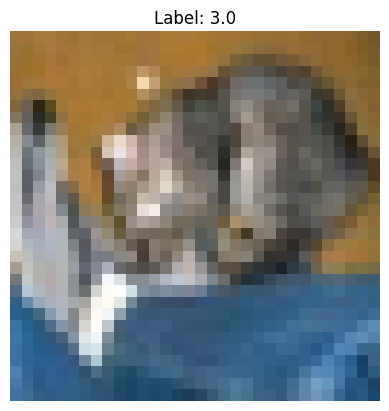

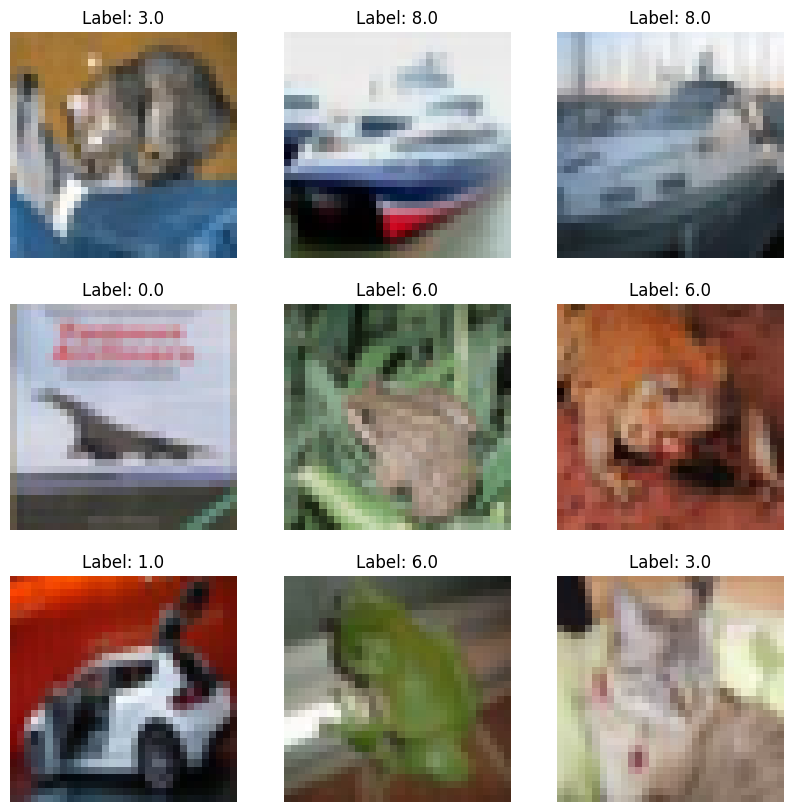

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming get_cifar() returns the data and labels
data, labels = get_cifar()[2]

# Transpose the images from (3, 32, 32) to (32, 32, 3)
data = np.transpose(test_trans_dat, (0, 2, 3, 1))

# Now, data[i] will be a 32x32x3 image and labels[i] will be the label for that image.

# To display a single image
plt.imshow(data[0])
plt.title(f"Label: {labels[0]}")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# To display multiple images in a grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(data[i])
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')  # Turn off axis numbers and ticks

plt.show()

In [102]:
def evaluate_model(net, test_data, test_labels, verbose=False):
    net.eval()
    correct = 0
    total = 0

    if isinstance(test_data, np.ndarray):
        test_data = torch.from_numpy(test_data).float()
    if isinstance(test_labels, np.ndarray):
        test_labels = torch.from_numpy(test_labels).long()

    with torch.no_grad():
        for i in range(len(test_data)):
            data = test_data[i].unsqueeze(0)  # Adding a batch dimension
            labels = test_labels[i].unsqueeze(0)  # Adding a batch dimension

            # Make sure the data is in [Batch, Channel, Height, Width] format
            if len(data.shape) == 4:
                data = data.permute(0, 3, 1, 2)

            data = data.to(net.conv1.weight.device)
            labels = labels.to(net.conv1.weight.device)

            outputs = net(data)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    if verbose:
        print(f'Accuracy of the network on the test data: {accuracy}%')

    return accuracy


In [103]:
evaluate_model(net, data, labels)

66.85

We have an accuracy of 66.85 when we test on the transformed dataset.